In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from yoeo.main import get_dv2_model, get_upsampler_and_expr, get_hr_feats, get_lr_feats
from yoeo.utils import load_image, convert_image, to_numpy, closest_crop, Experiment, do_2D_pca, add_flash_attention
from interactive_seg_backend import featurise_, FeatureConfig

from typing import Callable

SEED = 10672
np.random.seed(SEED)
torch.manual_seed(SEED)

N CPUS: 110


In [3]:
torch.cuda.empty_cache()

DEVICE = "cuda:0"

In [4]:
def rescale(arr: np.ndarray, swap_channels: bool=True) -> np.ndarray:
    if swap_channels:
        arr = np.transpose(arr, (1, 2, 0))
    h, w, c = arr.shape
    flat = arr.reshape((h * w, c))
    rescaled_flat = MinMaxScaler(clip=True).fit_transform(flat)
    return rescaled_flat.reshape((h, w, c))

In [5]:
img = Image.open('fig_data/needle_block.jpg')

In [6]:
classical_cfg = FeatureConfig()
classical_feats = featurise_(np.array(img), classical_cfg)

In [20]:
classical_reduced = do_2D_pca(classical_feats.transpose(-1, 0, 1), 3, post_norm='minmax')

In [7]:
dv2 = get_dv2_model(True, device=DEVICE)

model_path = "../trained_models/e5000_full_fit_reg.pth"
cfg_path = "../yoeo/models/configs/combined_no_shift.json"

upsampler, expr = get_upsampler_and_expr(model_path, cfg_path, device=DEVICE)

Using cache found in /home/ronan/.cache/torch/hub/ywyue_FiT3D_main


In [8]:
tr = closest_crop(img.height, img.width)
lr_feats, _ = get_lr_feats(dv2, [convert_image(img, tr)], fit3d=True)
lr_feats = F.interpolate(lr_feats, (img.height, img.width))

In [9]:
lr_feats_np = to_numpy(lr_feats)
lr_feats_np = rescale(lr_feats_np)

In [10]:
hr_feats = get_hr_feats(img, dv2, upsampler, DEVICE, n_ch_in=expr.n_ch_in)
hr_feats_np = to_numpy(hr_feats)
hr_feats_np = rescale(hr_feats_np)
print(hr_feats_np.shape)

(629, 750, 128)


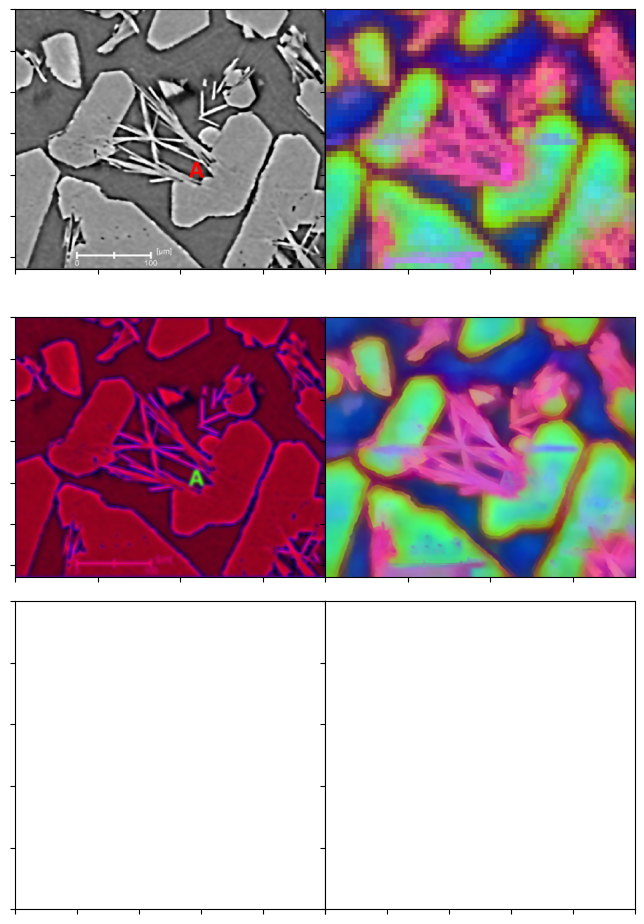

In [33]:
fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches((8, 12))

for a in axs.flatten():
    a.set_xticklabels([])
    a.set_yticklabels([])
    # a.set_aspect('equal')
    # a.set_axis_off()


axs[0, 0].imshow(img)
axs[0, 1].imshow(lr_feats_np[:, :, :3].astype(np.float64))
axs[1, 0].imshow(classical_reduced)
axs[1, 1].imshow(hr_feats_np[:, :, :3].astype(np.float64))

plt.subplots_adjust(wspace=0, hspace=0)